In [ ]:

# 8. Vẽ đồ thị loss, accuracy của training set và validation set
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch),H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch),H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch),H.history['acc'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch),H.history['val_acc'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()




# 9. Đánh giá model với dữ liệu test set
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)
# 10. Dự đoán ảnh
plt.imshow(X_test[0].reshape(28,28), cmap='gray')
y_predict = model.predict(X_test[0].reshape(1,28,28,1))
print('Giá trị dự đoán: ', np.argmax(y_predict))

In [ ]:
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
image = cv2.imread("/home/thinh/Bản tải về/con số.png",cv2.IMREAD_GRAYSCALE)
im_blur = cv2.GaussianBlur(image,(5,5),0)
im,thre = cv2.threshold(im_blur,90,255,cv2.THRESH_BINARY_INV)
_,contours,hierachy = cv2.findContours(thre,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(cnt) for cnt in contours]

for i in contours:
    (x,y,w,h) = cv2.boundingRect(i)
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),3)
    roi = thre[y:y+h,x:x+w]
    roi = np.pad(roi,(20,20),'constant',constant_values=(0,0))
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    y_predict = model.predict(roi.reshape(1,28,28,1))
    cv2.putText(image, str(int(np.argmax(y_predict))), (x, y),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
    print('Giá trị dự đoán: ', np.argmax(y_predict))

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
for j in range(len(contours)):
    stt=0
    (x1,y1,w1,h1)=(0,0,0,0)
    for i in contours:
        (x,y,w,h)= cv2.boundingRect(i)
        print(y1,y,j,stt)
        if (y1>y):
            tam=contours[stt]
            contours[stt]=contours[stt-1]
            contours[stt-1]=tam
            print(cv2.boundingRect(contours[stt-1]),cv2.boundingRect(contours[stt]))
        (x1,y1,w1,h1)=cv2.boundingRect(contours[stt])
        stt=stt+1
for i in contours:
    print(cv2.boundingRect(i))
print(np.shape(image))

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
Y=[]
f = open('/home/thinh/data/words.txt', 'r')

for i in range(115319):
    line = f.readline()
    tam=""
    for i in line:
        tam=tam+i
        if (i==" "):
            tam=""
    Y.append(tam[:len(tam)-1])

In [1]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import LSTM,Dense, Dropout, Activation, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Reshape, Lambda,Input
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [11]:
# 2. Load dữ liệu
lensample=20
tra_val=0.9
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    # print "y_pred_shape: ", y_pred.shape
    # print "y_pred_shape: ", y_pred.shape
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
X_train=[]
datadir="/home/thinh/data/words"
X_train=[]
address=sorted(glob.glob(os.path.join(datadir, "*","*","*")))
for im in address[:lensample]:
    image=cv2.imread(im,cv2.IMREAD_GRAYSCALE)
    [length_im,height_im]=image.shape
    if(length_im>32):
        image=cv2.resize(image,(height_im,32))
        length_im=32
    if(height_im>128):
        image=cv2.resize(image,(128,length_im))
        height_im=128
    tam=np.zeros((32,128))
    for i in range(length_im):
        tam[i][:height_im]=image[i][:height_im]
    image=tam
    X_train.append(image)
X_train=np.array(X_train).reshape(-1,32,128,1)
Y_train=[]
f = open('/home/thinh/data/words.txt', 'r')
for i in range(lensample):
    line = f.readline()
    line=line.split()
    if(len(line)>9):
        line=line[8]+' '+line[9]
    else:
        line=line[8]
    Y_train.append(line)

In [12]:

X_val, Y_val = X_train[int(lensample*tra_val):lensample], Y_train[int(lensample*tra_val):lensample]
X_train, Y_train = X_train[:int(lensample*tra_val)], Y_train[:int(lensample*tra_val)]
# 3. Reshape lại dữ liệu cho đúng kích thước mà keras yêu cầu
X_train = X_train.reshape(X_train.shape[0], 32, 128, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 128, 1)
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# 4. One hot encoding label (Y)
lenX_train=[31 for i in range(len(X_train))]
lenX_val=[31 for i in range(len(X_val))]
lengthY_train=[len(i) for i in Y_train ]
lengthY_val=[len(i) for i in Y_val ]
lengthY_train=np.array(lengthY_train)
lengthY_val=np.array(lengthY_val)
Y_train=np.array(Y_train)
Y_val=np.array(Y_val)
lenX_train=np.array(lenX_train)
lenX_val=np.array(lenX_val)
alphabet = " !"+'"'+"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# integer encode input data
integer_encoded=[]
for i in range(len(Y_train)):
    tam=np.zeros(19,dtype=int)
    tam[:len(Y_train[i])] = [char_to_int[char] for char in Y_train[i]]
    integer_encoded.append(tam)
#print(integer_encoded)
# one hot encode
integer_encoded1=[]
for i in range(len(Y_val)):
    tam=np.zeros(19,dtype=int)
    tam[:len(Y_train[i])] = [char_to_int[char] for char in Y_train[i]]
    integer_encoded1.append(tam)
integer_encoded=np.array(integer_encoded)
integer_encoded1=np.array(integer_encoded1)
#print(integer_encoded)
# one hot encode

In [4]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='ocr1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [16]:


# 5. Định nghĩa model
from keras.layers.merge import add, concatenate
input_shape = (32, 128, 1)     # (128, 64, 1)

    # Make Networkw
inputs = Input(name='the_input', shape=input_shape, dtype='float32')  # (None, 128, 64, 1)

    # Convolution layer (VGG)
inner = Conv2D(64, (3, 3), padding='same', name='conv1', activation='relu')(inputs)  # (None, 32,128,64)
inner1 = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

inner2 = Conv2D(128, (3, 3), padding='same', name='conv2', activation='relu' )(inner1)  # (None, 16, 64, 128)
inner3 = MaxPooling2D(pool_size=(2, 2), name='max2')(inner2)  # (None, 32, 16, 128)

inner4 = Conv2D(512, (3, 3), padding='same', name='conv3',activation='relu')(inner3)  # (None, 8, 32, 256)
inner5 = MaxPooling2D(pool_size=(2, 1), name='max3')(inner4)  # (None, 32, 8, 256)

inner6 = Conv2D(1024, (3, 3), padding='same', name='conv5', activation='relu')(inner5)  # (None, 4, 32, 512)
inner7 = MaxPooling2D(pool_size=(2, 1), name='max4')(inner6)  # (None, 32, 4, 512)
#inner7b = BatchNormalization()(inner7)
inner8 = Conv2D(512, (2, 2), padding='same',  activation='relu', name='con7')(inner7)  # (None, 2, 32, 512)
inner9 = MaxPooling2D(pool_size=(2, 1), name='max5')(inner8)


    # CNN to RNN
inner10 = squeezed = Lambda(lambda x: K.squeeze(x, 1))(inner9)  # (None, 32, 2048)
#inner = Dense(256, activation='relu', name='dense1')(inner)  # (None, 32, 64)

    # RNN layer

  # (None, 32, 512)
    
lstm_1 = LSTM(512, return_sequences=True, go_backwards=True,name='lstm1')(inner10)
lstm_2 = LSTM(256, return_sequences=True, go_backwards=True, name='lstm2')(lstm_1)
#reversed_lstm_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_2b)

#lstm2_merged = concatenate([lstm_2, reversed_lstm_2b])  # (None, 32, 1024)

    # transform1s RNN output to character activations:
y_pred = Dense(80,activation='softmax',name='dense2')(lstm_2) #(None, 32, 63)

labels = Input(name='the_labels', shape=[19], dtype='float32') # (None ,8)
input_length = Input(name='input_length', shape=[1], dtype='int64')     # (None, 1)
label_length = Input(name='label_length', shape=[1], dtype='int64')     # (None, 1)

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
loss_out = Lambda(ctc_lambda_func,output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)
model = Model(inputs=[inputs, labels, input_length, label_length],outputs=loss_out)
model1= Model(inputs=inputs ,outputs=y_pred)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam',metrics=['accuracy'])
model.fit(x=[X_train,integer_encoded,lengthY_train,lenX_train], y=np.zeros(len(X_train)),validation_data=([X_val,integer_encoded1,lengthY_val,lenX_val],[np.zeros(len(X_val))]),batch_size=64, epochs=10, verbose=1)
#,callbacks = callbacks_list

Train on 18 samples, validate on 2 samples
Epoch 1/10
18/18 [==============================] - 11s 618ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
18/18 [==============================] - 4s 222ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
18/18 [==============================] - 4s 219ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
18/18 [==============================] - 4s 220ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
18/18 [==============================] - 4s 215ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
18/18 [==============================] - 4s 219ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
18/18 [==============================] - 4s 2

In [19]:
model1= Model(inputs=inputs ,outputs=y_pred)
prediction = model1.predict(X_train[:10])
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=False,)[0][0])
#beam_width=128, top_paths=1

In [20]:
i = 0
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
for x in out:
    print("original_text =  ", Y_train[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(int_to_char[int(p)], end = '')       
    print('\n')
    i+=1


original_text =   A
predicted text = w:c:c:AeAe(e(e

original_text =   MOVE
predicted text = w:wcwcwdwdwdwd:c

original_text =   to
predicted text = w:wcwcwc:c:AfAe

original_text =   stop
predicted text = w:wcwcwcwcwcwc:c

original_text =   Mr.
predicted text = wdwdwdwcwcdwcwc:

original_text =   Gaitskell
predicted text = wdwdwdwdwdwcwc:

original_text =   from
predicted text = wdwdwdwcwcwcwc:

original_text =   nominating
predicted text = wcwcwcwcwcwcwc:

original_text =   any
predicted text = wcwcwcwcwcwcwc:c

original_text =   more
predicted text = dwdwdwdwdwcwcwc:



In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 32, 128, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 128, 64)  640         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 16, 64, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 16, 64, 128)  73856       max1[0][0]                       
____________________________________________________________________________________________

In [22]:
model2=Model(inputs=[inputs, labels, input_length, label_length],outputs=loss_out)
a = model2.predict([X_train[:5],integer_encoded[:5],lengthY_train[:5],lenX_train[:5]])
import matplotlib.pyplot as plt
print(a)


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


['from' 'nominating']
(2, 32, 512)


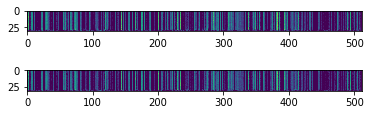

In [129]:
import time
e=range(6,8)
model3=Model(inputs=inputs,outputs=inner10)
b=model3.predict(X_train[e])
print(Y_train[e])
print(b.shape)
fig=plt.figure()
for i in range(1,3):
    pic=b[i-1][:,:]
    #print(pic.shape)
    fig.add_subplot(i,1,1)
    plt.imshow(pic)
    #print('\n')

    


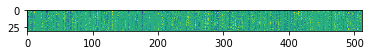

In [9]:
weight=[]
for layer in model.layers:
    weights = layer.get_weights() 
    weight.append(weights)# list of numpy arrays

In [51]:
K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)

([<tf.Tensor: shape=(10, 8), dtype=int64, numpy=
  array([[ 6, 24, 75, 73, 47, -1, -1, -1],
         [ 6, 28,  6, -1, -1, -1, -1, -1],
         [36,  6, 24, 71, 24, 75, 70, 73],
         [ 6, -1, -1, -1, -1, -1, -1, -1],
         [ 6, 28,  6, -1, -1, -1, -1, -1],
         [77,  6, 28,  6, -1, -1, -1, -1],
         [ 6, -1, -1, -1, -1, -1, -1, -1],
         [ 6, -1, -1, -1, -1, -1, -1, -1],
         [41,  6, 28,  6, -1, -1, -1, -1],
         [ 6, -1, -1, -1, -1, -1, -1, -1]])>],
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[133.60512 ],
        [120.365944],
        [125.40505 ],
        [119.19931 ],
        [119.51681 ],
        [118.87883 ],
        [120.59592 ],
        [119.77333 ],
        [119.565025],
        [119.02488 ]], dtype=float32)>)

In [69]:
s=0
for j in range(32):
    b=dict((c, i) for i, c in enumerate(prediction[s][j]))
    print(b[max(prediction[s][j])])


6
6
6
6
6
6
6
6
24
24
24
24
24
24
75
75
75
75
73
73
73
73
73
73
73
73
73
73
73
47
47
47


In [90]:
Y_train[20:30]

array(['of', 'Labour', 'M Ps', 'tomorrow', '.', 'Mr.', 'Michael', 'Foot',
       'has', 'put'], dtype='<U16')